In [2]:
import numpy as np
import scipy as sp
import spiceypy as spice
from scipy import constants
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import jplephem as jpl #jpl spk, open kernal , date -> days
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon, get_body_barycentric_posvel
from astropy.visualization import quantity_support
from astropy import units as u
from jplephem.spk import SPK

In [29]:
#CONSTANTS
G = constants.G
c = constants.speed_of_light
AU = 1.496e8 #km
JD = 3600*24 #s

#MASSES
M_sun = 1.99e30
M_merc = 3.30e23 
M_venus = 4.87e24
M_earth = 5.97e24
M_moon = 7.35e22
M_mars = 6.42e23
M_jup = 1.90e27
M_sat = 5.68e26
M_uran = 8.68e25
M_nept = 1.02e26
M_pluto = 1.31e22
ss_mass = [M_sun, M_merc, M_venus, M_earth, M_moon, M_mars, M_jup, M_sat, M_uran, M_nept, M_pluto]

#SEM system
SEM = ['sun','earth','moon']
sem_masses = [M_sun, M_earth, M_moon]

In [4]:
#JPL Model of the Solar System
solar_system_ephemeris.set('de430.bsp') #file path
#directory: https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/
solar_bodies = list(solar_system_ephemeris.bodies) #list of bodies, tuple to list
solar_bodies.remove('earth-moon-barycenter')
print("list of bodies:", solar_bodies)

t1 = Time("2020-10-11 23:22")#set the time
t2 = Time("2020-11-11 23:22") 
t3 = Time("2020-12-11 23:22") 

def All_positions(t,bodies=solar_bodies) :
    """
    Returns a list of the positions of all the bodies in the solar system at a given time t, list
    """
    allp = []
    for sb in bodies:
        allp.append(list(get_body_barycentric(sb,t).get_xyz().to_value()))
    return allp

t1pos = All_positions(t1)
t2pos = All_positions(t2)
t3pos = All_positions(t3)


list of bodies: ['sun', 'mercury', 'venus', 'earth', 'moon', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune', 'pluto']


In [31]:
#solar_system_ephemeris.set('L2_de431.bsp') 
#solar_bodies = list(solar_system_ephemeris.bodies)
#print(solar_bodies)

In [32]:
#solar_system_ephemeris.bodies 

In [5]:
def PlotStationarySS2d(xs,bodies=solar_bodies,):
    """
    INPUT:
    xs- positions, list
    bodies- list of bodies
    """
    plt.figure(figsize=(20,6)) #The Solar System in the x-y plane
    #Plot the bodies
    for pos in xs:
        i = xs.index(pos)
        plt.plot(pos[0],pos[1],'x',label = bodies[i] )
    plt.legend()
    plt.title('Stationary Solar System')
    #plt.xlim(-0.5e9,7e9)
    plt.show()
    
#PlotStationarySS2d(t1pos)
#PlotStationarySS2d(t2pos)
#PlotStationarySS2d(t3pos)

In [6]:
def PlotStationarySS3d(xs,bodies=solar_bodies,):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection = '3d')
    for pos in xs:
        i = xs.index(pos)
        ax.scatter3D([pos[0]], [pos[1]], [pos[2]], cmap = 'Greens',label = bodies[i])
    plt.legend()
    plt.title('Stationary Solar System')
    plt.show()

#PlotStationarySS3d(t1pos)
#PlotStationarySS3d(t2pos)
#PlotStationarySS3d(t3pos)

In [7]:
#Solar System Orbit F(t)
t_i = Time("2000-09-27 11:11")

def Orbits (ti, d=2, dt=2000, ntdata = 100, bodies = solar_bodies, plot=True, plotvel=True): 
    """
    INPUT: 
    ti - start time in isot
    dt - interval in JD
    ntdata - no. of t data
    bodies- list of bodies
    
    OUTPUT:
    positions - matrix of positions
    allt - time sequence
    """
    print("D =",d) #check
    n_b = len(bodies) #number of bodies
    #create empty 2x2 arrays
    positions = np.empty([n_b, ntdata, 3]) #rows=bodies
    velocities = np.empty([n_b, ntdata])
    
    #all time
    allt = ti + dt * np.linspace(0., 1., ntdata)
    print("end time =", allt[-1])
    
    for i in range(n_b):
        for j in range (ntdata):
            output = get_body_barycentric_posvel(bodies[i],allt[j]) #get position and velocity
            positions[i][j] = list((output[0].get_xyz().to_value())*6.68459e-9) #unit = AU
            velocities[i][j] = np.linalg.norm(output[1].get_xyz().to_value()) #magvel, unit = AU/day
    
    if plot == True:
        #2D
        if d == 2:
            plt.figure(figsize=(20,6))
            for i in range(n_b):
                x_singlebody = np.transpose(positions[i])
                plt.plot(x_singlebody[0],x_singlebody[1],'--',label=bodies[i])
            plt.legend()
            plt.title('Solar System Orbits')
            plt.show()

        
        #3D
        if d == 3:
            fig = plt.figure(figsize=(10,10))
            ax = fig.add_subplot(projection = '3d')
            for i in range (n_b):
                x_singlebody = np.transpose(positions[i])
                ax.plot3D(x_singlebody[0],x_singlebody[1],x_singlebody[2],label = bodies[i])
            plt.legend()
            plt.title('Solar System Orbits')
            plt.show()
    
    #plot velocity
    if plotvel == True:
        plt.figure(figsize=(20,6))
        allt_jd = np.empty(len(allt))
        for nt in range(len(allt)):
            allt_jd[nt] = allt[nt].jd
        for i in range(n_b):
            v_singlebody = velocities[i]
            plt.plot(allt_jd,v_singlebody,'--',label=bodies[i])
        plt.legend()
        plt.title('Solar System Velocities')
        plt.ylabel('v (AU/day)')
        plt.xlabel('t (JD)')
        plt.show()
            
      
    return positions, allt, velocities

D = 2
end time = 2006-03-20 11:10:59.000


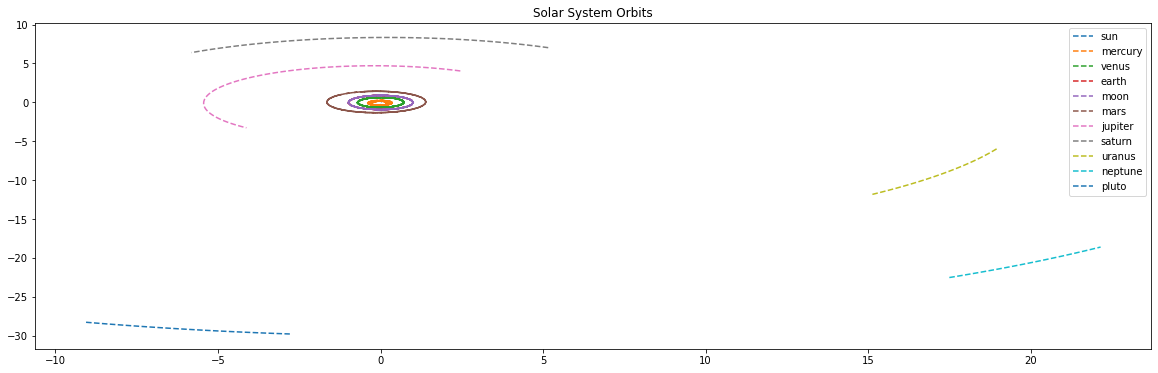

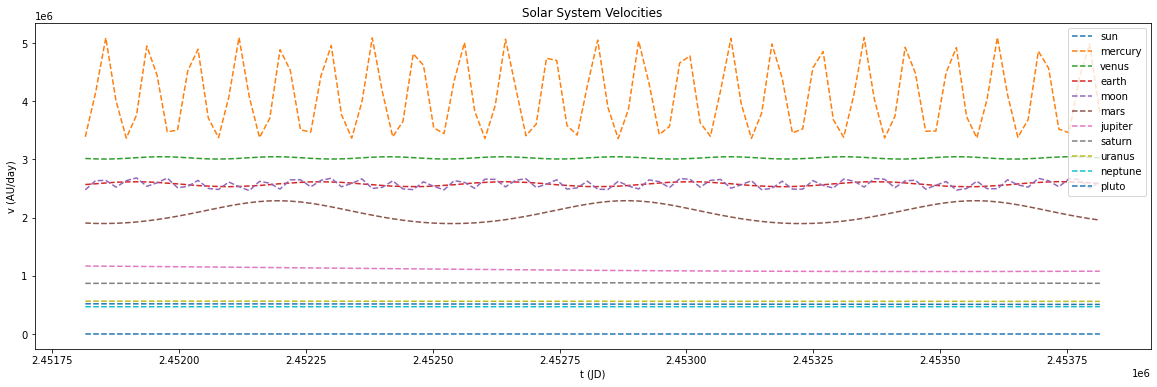

(array([[[-5.38091764e-03, -4.18843941e-03, -1.62932281e-03],
         [-5.22830040e-03, -4.27849747e-03, -1.67188588e-03],
         [-5.07273571e-03, -4.36484821e-03, -1.71295887e-03],
         ...,
         [ 3.76967906e-03,  2.28656687e-03,  8.63361601e-04],
         [ 3.70604945e-03,  2.40029380e-03,  9.12883646e-04],
         [ 3.63820629e-03,  2.51219823e-03,  9.61754569e-04]],
 
        [[-1.42100646e-03, -4.12839614e-01, -2.20325801e-01],
         [ 3.45907246e-01, -1.28622217e-01, -1.04508367e-01],
         [ 2.22599093e-02,  2.67370650e-01,  1.40603073e-01],
         ...,
         [ 3.62678456e-01, -1.97946266e-02, -4.81497079e-02],
         [-1.04527163e-01,  2.59577325e-01,  1.49512997e-01],
         [-3.83365596e-01, -1.56217744e-01, -4.36959591e-02]],
 
        [[-1.91407020e-01, -6.48485961e-01, -2.79717328e-01],
         [ 2.09256270e-01, -6.33310253e-01, -2.98239023e-01],
         [ 5.44517208e-01, -4.26020844e-01, -2.26192190e-01],
         ...,
         [-6.42915397e

In [8]:
#2D Orbits
Orbits (t_i)

D = 3
end time = 2000-09-27 07:59:39.000


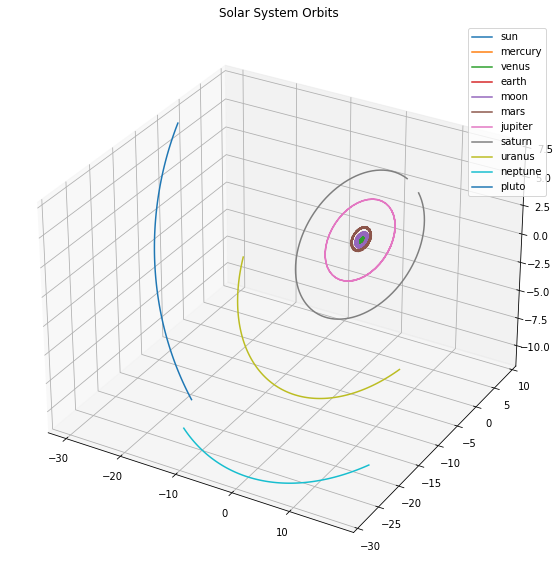

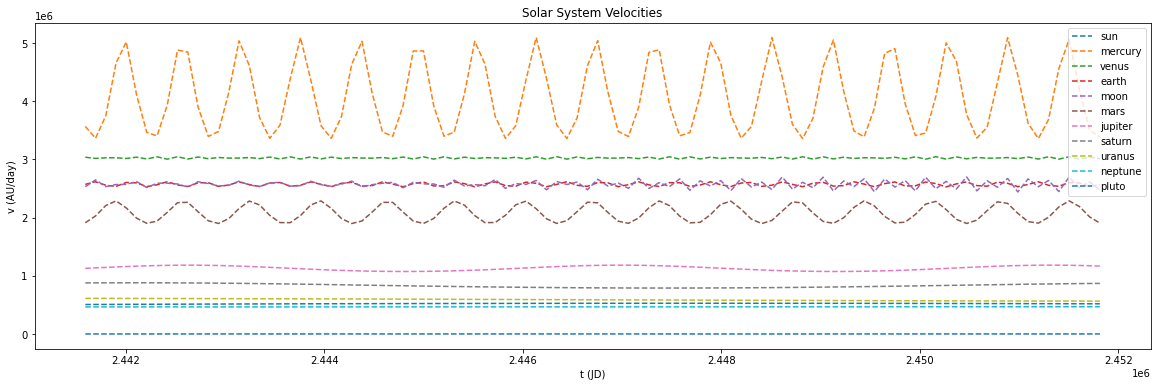

(array([[[-2.89149716e-04,  3.69038533e-03,  1.62197959e-03],
         [-8.40049958e-04,  3.45222133e-03,  1.53076495e-03],
         [-1.35582528e-03,  3.12743900e-03,  1.40131331e-03],
         ...,
         [-6.77901427e-03, -3.06061469e-03, -1.10930049e-03],
         [-6.12129431e-03, -3.67162761e-03, -1.38841631e-03],
         [-5.38191228e-03, -4.18783545e-03, -1.62903817e-03]],
 
        [[-3.36738757e-01, -2.64703803e-01, -1.06810280e-01],
         [-5.12048556e-02, -4.07253875e-01, -2.12605500e-01],
         [ 2.65352724e-01, -2.75992290e-01, -1.75362055e-01],
         ...,
         [-3.84818604e-01,  1.06775633e-02,  4.54370116e-02],
         [-3.10879096e-01, -3.09126337e-01, -1.32943179e-01],
         [-4.41072906e-03, -4.13135858e-01, -2.20174114e-01]],
 
        [[ 1.65785799e-01,  6.46946142e-01,  2.80439273e-01],
         [-3.24527459e-01, -5.95727810e-01, -2.47483000e-01],
         [ 4.87442151e-01,  4.99651677e-01,  1.93788252e-01],
         ...,
         [ 1.66300873e

In [9]:
#3d Orbits
Orbits (Time("1972-10-02 08:00"), 3, 10222)

D = 3
end time = 2003-06-24 11:11:00.000


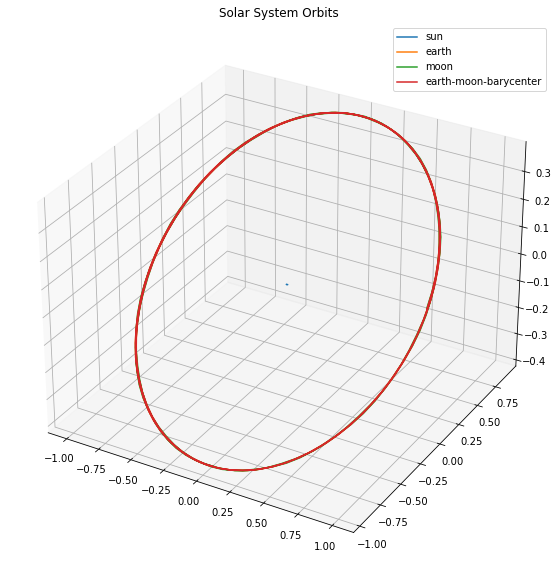

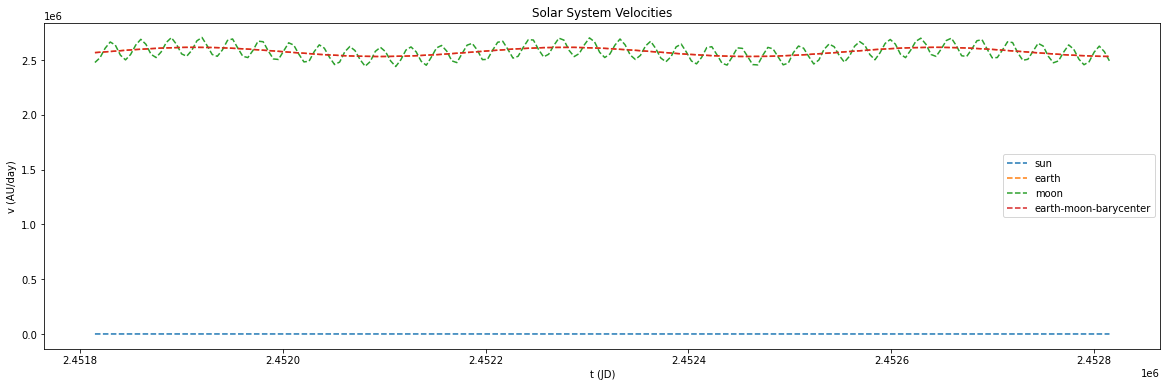

In [10]:
#SEM System
sem = ['sun','earth','moon','earth-moon-barycenter']
output1 = Orbits (t_i, 3, 1000, 200, sem) #1000days
sempos, ts = output1[0], output1[1]

se_distance = [] #sun-earth
em_distance = [] #earth-moon
sm_distance = [] #sun-moon
earth_d = [] #earth-embarycenter
moon_d = [] #moon-embarycenter

for i in range(len(ts)):
        se_distance.append(np.linalg.norm(sempos[0][i]-sempos[1][i]))
        em_distance.append(np.linalg.norm(sempos[1][i]-sempos[2][i]))
        sm_distance.append(np.linalg.norm(sempos[0][i]-sempos[2][i]))
        earth_d.append(np.linalg.norm(sempos[3][i]-sempos[1][i]))
        moon_d.append(np.linalg.norm(sempos[3][i]-sempos[2][i]))

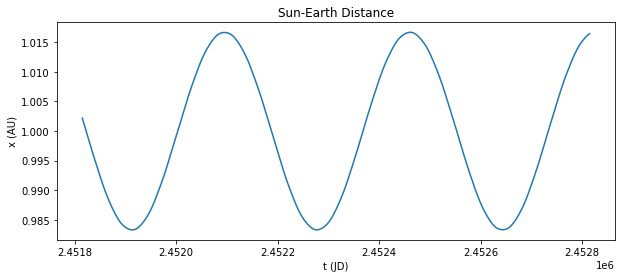

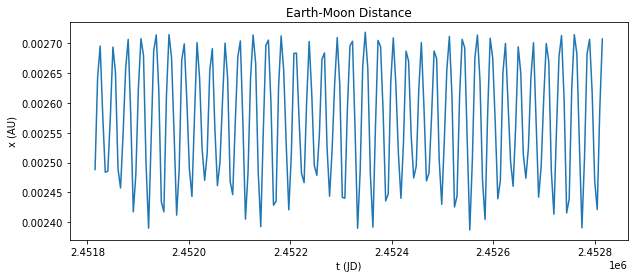

In [11]:
#Sun-Earth & Earth-Moon
plt.figure(figsize=(10,4))
plt.plot(ts.jd, se_distance)
plt.title("Sun-Earth Distance")
plt.xlabel("t (JD)")
plt.ylabel("x (AU)")

plt.figure(figsize=(10,4))
plt.plot(ts.jd, em_distance)
plt.title("Earth-Moon Distance")
plt.xlabel("t (JD)")
plt.ylabel("x (AU)")

plt.show()

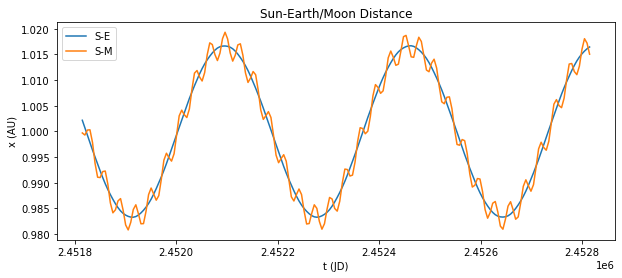

In [12]:
#Sun-Earth/Moon
plt.figure(figsize=(10,4))
plt.plot(ts.jd, se_distance, label='S-E')
plt.plot(ts.jd, sm_distance, label='S-M')
plt.title("Sun-Earth/Moon Distance")
plt.xlabel("t (JD)")
plt.ylabel("x (AU)")
plt.legend()                        
plt.show()


In [36]:
#Relative Distances

def RelDist(t,R,bodies,allpos,plot=True):
    """
    t=time array
    R = position of a given POINT relative to the SUN
    bodies = list of bodies --- MAKE SURE 'sun' IS THE FIRST ITEM!!
    allpos=array of pos
    """
    r_sun = allpos[0] #position of the sun
    
    relpos=[] #list for all planet positions relative to the sun
    for i in range(len(bodies)):
        relative_r = r_sun - allpos[i]
        relpos.append(relative_r)
    
    #making R a list
    posR = len(t)*[R]
    
    posSB = [] #list for positions of point relative to all the bodies
    for i in relpos:
        posSB.append(posR - i)
    
    
    #calculating the norm of vectors
    rSB = np.empty([len(posSB),(len(posSB[0]))])
    for i in range(len(posSB)):
        for j in range(len(posSB[0])):
            rSB[i][j] = np.linalg.norm(posSB[i][j])
    
    #plot
    if plot == True:
        plt.figure(figsize=(20,6))
        for i in range(len(rSB)):
            plt.plot(t.jd, rSB[i], label=bodies[i])
        plt.xlabel('t (JD)')
        plt.ylabel('x (AU)')
        plt.legend()
        plt.title('Relative Distances')
        plt.show()
    
    return posSB, rSB

output2 = Orbits (t_i, 2, 6000, 500, solar_bodies,False, False) #6000days
all_sb_pos, t2 = output2[0], output2[1]

D = 2
end time = 2017-03-02 11:10:55.000


In [14]:
#TIME DILATION between A & B outside a spherical mass
#Take Ref dtauA 
#dtau_B = (dtauA /(1 - GM/r_A + GM/r_B))
#if r_A < r_B, i.e. B at a higher potential -->  dtau_B/dtau_A > 1 & vice versa

 
def GravTD(M,r_A,r_B,tauA=1): #all distances in AU
    #return (1/(1-((G*M)/(r_A*AU*(c**2))+((G*M)/(r_B*AU*(c**2))))))-1
    return ((((G*M)/(r_A*AU*(c**2)))-((G*M)/(r_B*AU*(c**2))))*tauA)/(1-((G*M)/(r_A*AU*(c**2)))+((G*M)/(r_B*AU*(c**2))))


In [15]:
#TD TEST
GravTD(M_earth,1000/AU,2000/AU)

1.0000066501707454

In [16]:
#%%capture
#THE LAGRANGE POINTS, R=1AU
L1 = [(1-((M_earth/(M_sun + M_earth))**(1/3))),0.,0.]
L2 = [(1+((M_earth/(M_sun + M_earth))**(1/3))),0.,0.]
L3 = [(-1-((5*M_earth)/(12*(M_sun + M_earth)))),0.,0.]
L4 = [0.5*((M_sun - M_earth)/(M_sun + M_earth)),(np.sqrt(3))/(2),0.]
L5 = [0.5*((M_sun - M_earth)/(M_sun + M_earth)),-(np.sqrt(3))/(2),0.]

LP_pos = np.vstack([L1,L2,L3,L4,L5,S,E])
plt.plot(np.transpose(LP_pos)[0],np.transpose(LP_pos)[1],'x')
plt.plot([0.,1.],[0.,0.],'x',color='r')
plt.xlabel('x(AU)')
plt.ylabel('y(AU)')
plt.show()

In [17]:
def Delta_t (R1, R2, t, bodies = solar_bodies, masses=ss_mass, pos = all_sb_pos):
    """
    R1,R2 are positions of the points relative to the sun
    """
    #First calculate the distances relative to all the bodies
    #R1
    outputR1 = RelDist(t,R1,bodies,pos,False)
    allreldist1 =outputR1[1]
    #R2
    outputR2 = RelDist(t,R2,bodies,pos,False)
    allreldist2 = outputR2[1]
    
    #create an empty array
    dts = np.empty([len(bodies),len(t)])
    
    #Perform comparisons
    for i in range(len(bodies)):
        for j in range (len(t)):
            dts[i][j] = GravTD(masses[i],allreldist1[i][j],allreldist2[i][j])
    #PLOT
    plt.figure(figsize=(20,6))
    for i in range(1,len(dts)):
        plt.plot(t.jd, dts[i], label=bodies[i])
    plt.plot(t.jd,dts[0],label='SUN',color='r')
    plt.xlabel('t (JD)')
    plt.ylabel('seconds at B gained per second at A (s)')
    plt.yscale('log')
    plt.legend()
    plt.title('Time Difference')
    plt.show()
    return dts

In [22]:
#%%capture
Delta_t(L4,L5,t2)

In [23]:
#%%capture
Delta_t(L1,L2,t2)

In [24]:
#%%capture
Delta_t(L1,L4,t2)

In [27]:
#%%capture
Delta_t(L3,L2,t2)

In [30]:
def dtau (M,r,dt):
    """
    dt in JD
    r in AU
    
    dtau = proper time at r due to M in s
    """
    dtau = (np.sqrt(1-((2*G*M)/(r*AU*((c)**2)))))*dt*JD
    return dtau

#tests                
print(dtau(M_earth,0.3,1))
print(dtau(M_earth,0.4,1))
print(dtau(M_sun,0.3,1))
print(dtau(M_sun,0.001,1))

86399.99999146507
86399.99999359882
86397.15497924616
85542.25010113021


In [31]:
output3 = Orbits (t_i, 2, 6000, 6000, solar_bodies,False, False)
allpos, t3 = output3[0], output3[1]

D = 2
end time = 2017-03-02 11:10:55.000


In [32]:
t_i1 = Time("1973-06-12 11:11")
output4 = Orbits (t_i1, 2, 6000, 6000, solar_bodies,False, False)
allpos4, t4 = output4[0], output4[1]

D = 2
end time = 1989-11-15 11:10:48.000


In [33]:
t_i2 = Time("1966-10-02 11:11")
output5 = Orbits (t_i2, 2, 20000, 20000, solar_bodies,False, False)
allpos5, t5 = output5[0], output5[1]

D = 2
end time = 2021-07-05 11:10:28.025


In [34]:
def IntDelta_t(R1,R2,dt,t = t3,bodies = solar_bodies, masses=ss_mass, pos = allpos):
    Intdts = np.empty([len(bodies),len(t)])

    #R1
    outputR1 = RelDist(t,R1,bodies,pos,False)
    allreldist1 =outputR1[1]
    int_tau1 = np.empty([len(bodies),int(len(t)/dt)]) #NB sample size lent/dt must be an int
    
    #R2
    outputR2 = RelDist(t,R2,bodies,pos,False)
    allreldist2 = outputR2[1]
    int_tau2 = np.empty([len(bodies),int(len(t)/dt)])
    
    #no.days
    #N_days = np.arange(len(t))
    days = np.linspace(t.jd[0],t.jd[-1],int(len(t)/dt))
    
    #calculate tau on each dt, loop through and sum (i.e. integrate)
    sumtau1 = 0
    sumtau2 = 0
    for i in range(len(int_tau1)):
        for j in range(len(int_tau1[0])):
            sumtau1 += dtau(masses[i],allreldist1[i][j],dt)
            int_tau1[i][j] = sumtau1
            
            sumtau2 += dtau(masses[i],allreldist2[i][j],dt)
            int_tau2[i][j] = sumtau2
        sumtau1 = 0
        sumtau2 = 0
        
    print("pluto")
    print(int_tau1[-1])
    print("")
    print(int_tau2[-1])
    #delay
    rel_delay = abs(int_tau2 - int_tau1)
 
    #PLOT
    plt.figure(figsize=(20,6))
    for i in range(1,len(rel_delay)):
        plt.plot(days, rel_delay[i], label=bodies[i])
    plt.plot(days,rel_delay[0],label='SUN',color='b')
    plt.xlabel('t (JD)')
    plt.ylabel('dtauB-dtauA (s)')
    plt.yscale('log')
    plt.legend()
    plt.title('Relative Delay')
    plt.show()
    
    return rel_delay

pluto
[1.728000e+05 3.456000e+05 5.184000e+05 ... 5.180544e+08 5.182272e+08
 5.184000e+08]

[1.728000e+05 3.456000e+05 5.184000e+05 ... 5.180544e+08 5.182272e+08
 5.184000e+08]


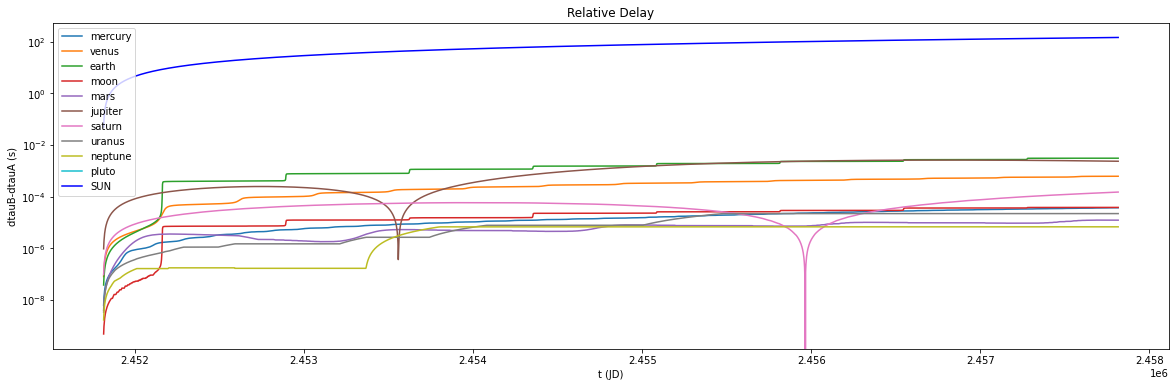

[0. 0. 0. ... 0. 0. 0.]


In [37]:
op = IntDelta_t(L1,L2,2)
print(op[-1]) #pluto

pluto
[8.640000e+04 1.728000e+05 2.592000e+05 ... 5.182272e+08 5.183136e+08
 5.184000e+08]

[8.640000e+04 1.728000e+05 2.592000e+05 ... 5.182272e+08 5.183136e+08
 5.184000e+08]


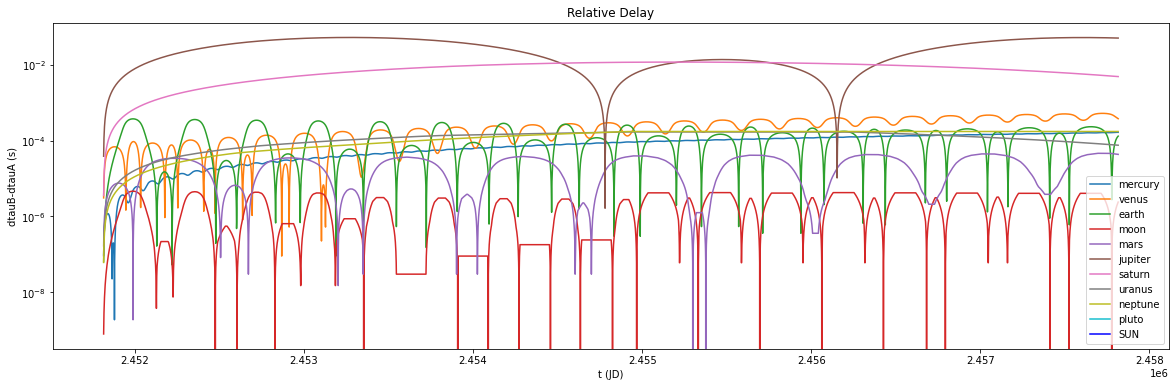

[0. 0. 0. ... 0. 0. 0.]


In [38]:
op2 = IntDelta_t(L4,L5,1)
print(op2[-1])

pluto
[8.640000e+04 1.728000e+05 2.592000e+05 ... 5.182272e+08 5.183136e+08
 5.184000e+08]

[8.640000e+04 1.728000e+05 2.592000e+05 ... 5.182272e+08 5.183136e+08
 5.184000e+08]


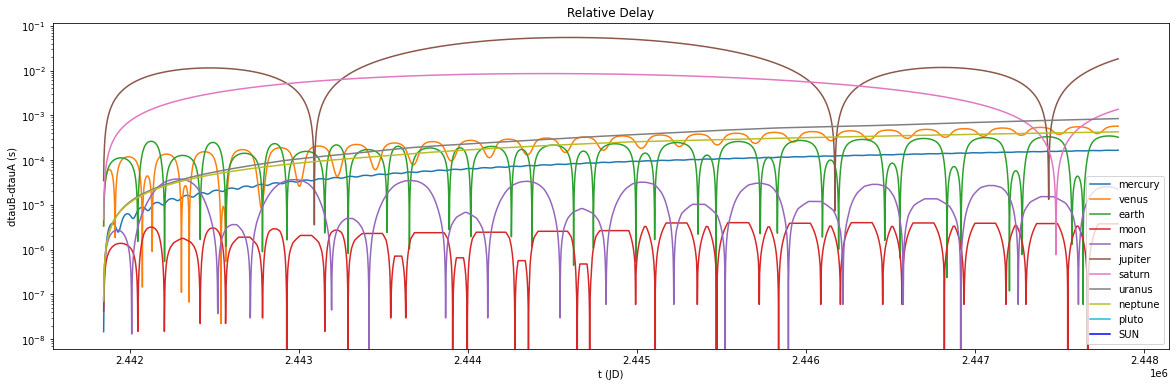

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.46537786e-08, 3.82133294e-08, 7.06641003e-08, ...,
        1.65820122e-04, 1.65939331e-04, 1.66058540e-04],
       [3.34458309e-06, 6.65732659e-06, 9.92498826e-06, ...,
        5.71012497e-04, 5.70833683e-04, 5.70654869e-04],
       ...,
       [7.18719093e-08, 1.43802026e-07, 2.15746695e-07, ...,
        8.42928886e-04, 8.43107700e-04, 8.43286514e-04],
       [7.16827344e-08, 1.43365469e-07, 2.15048203e-07, ...,
        4.26292419e-04, 4.26352024e-04, 4.26411629e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [39]:
IntDelta_t(L4,L5,1,t4,solar_bodies,ss_mass,allpos4)

pluto
[8.6400000e+04 1.7280000e+05 2.5920000e+05 ... 1.7278272e+09 1.7279136e+09
 1.7280000e+09]

[8.6400000e+04 1.7280000e+05 2.5920000e+05 ... 1.7278272e+09 1.7279136e+09
 1.7280000e+09]


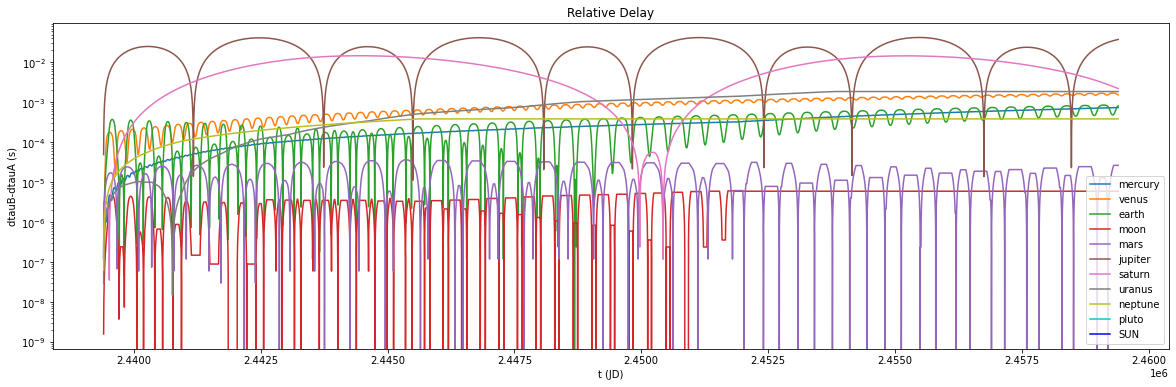

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.26077794e-07, 2.51835445e-07, 3.76458047e-07, ...,
        7.43389130e-04, 7.43627548e-04, 7.43865967e-04],
       [7.29603926e-07, 1.36197195e-06, 1.89809361e-06, ...,
        1.54781342e-03, 1.54733658e-03, 1.54685974e-03],
       ...,
       [2.96568032e-08, 5.92845026e-08, 8.88539944e-08, ...,
        1.86777115e-03, 1.86777115e-03, 1.86777115e-03],
       [6.25150278e-08, 1.25030056e-07, 1.87545083e-07, ...,
        3.85522842e-04, 3.85522842e-04, 3.85522842e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [40]:
IntDelta_t(L4,L5,1,t5,solar_bodies,ss_mass,allpos5)

pluto
[8.6400000e+04 1.7280000e+05 2.5920000e+05 ... 1.7278272e+09 1.7279136e+09
 1.7280000e+09]

[8.6400000e+04 1.7280000e+05 2.5920000e+05 ... 1.7278272e+09 1.7279136e+09
 1.7280000e+09]


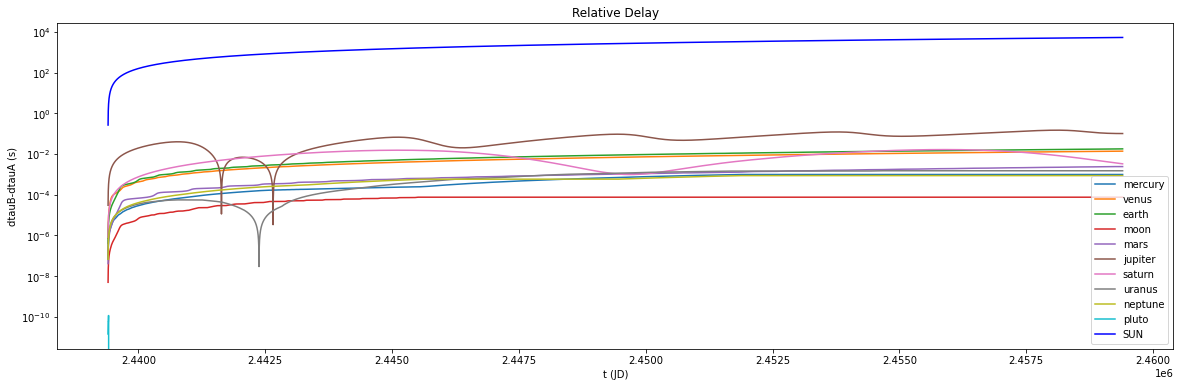

array([[2.64659662e-01, 5.29319324e-01, 7.93978986e-01, ...,
        5.29266376e+03, 5.29292842e+03, 5.29319308e+03],
       [6.66186679e-08, 1.32888090e-07, 1.98750058e-07, ...,
        9.88721848e-04, 9.88721848e-04, 9.88721848e-04],
       [7.38335075e-07, 1.48953404e-06, 2.25391705e-06, ...,
        1.38161182e-02, 1.38168335e-02, 1.38177872e-02],
       ...,
       [7.08241714e-08, 1.41590135e-07, 2.12312443e-07, ...,
        1.50513649e-03, 1.50513649e-03, 1.50513649e-03],
       [6.74917828e-08, 1.34983566e-07, 2.02475348e-07, ...,
        8.67843628e-04, 8.67843628e-04, 8.67843628e-04],
       [1.45519152e-11, 2.91038305e-11, 5.82076609e-11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [41]:
IntDelta_t([1,1,1],[1,2,3],1,t5,solar_bodies,ss_mass,allpos5) #random position